In [11]:
#pySnowRadar modules
import sys
%matplotlib inline

# from pySnowRadar import SnowRadar
# from pySnowRadar.processing import extract_layers
# from pySnowRadar.algorithms import Wavelet_TN, Peakiness

from msc_thesis_functions import *
del sys.modules['msc_thesis_functions']
from msc_thesis_functions import *
import pickle

#Community packages
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from datetime import datetime, timedelta
from thefuzz import process, fuzz
from scipy.spatial.distance import cdist
from tqdm import tqdm
import h5py
import cmasher as cmr
import xarray as xr
from scipy.stats import linregress
import matplotlib.colors as mcolors
from pyproj import Transformer
from shapely.geometry import Polygon, Point, MultiPoint, LineString
from shapely import affinity

import numpy as np
import shapely
import seaborn as sns
from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)


pd.options.mode.chained_assignment = None  # default='warn'

from matplotlib.colors import LinearSegmentedColormap

ncolors = 256
color_array = plt.get_cmap('Blues')(range(ncolors))
color_array[:,-1] = np.linspace(0.2,1,ncolors)
map_object = LinearSegmentedColormap.from_list(name='Blues_alpha',colors=color_array)
# 
# register this new colormap with matplotlib
# plt.colormaps.register(cmap=map_object)

from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)

from scipy.constants import speed_of_light


import matplotlib.font_manager as font_manager

font_path= '/Users/torka/Library/Fonts/FiraSans-Light.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

import geopandas as gpd

In [219]:
sites = ['transect']
year = '2014'
#opening ATM grids
# path_ATM= '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM_gridded/gridding_v7'
# files = os.listdir(path_ATM)
# ATM_data_dict = {}
# # print('Opening ATM data:')
# for site in sites:
#     file = [x for x in files if x.split('_')[-1].split('.')[0] == str(site)][0]
#     # print(f'{site}: {file}')
#     ds = xr.open_dataset(os.path.join(path_ATM, file))
#     ATM_data_dict[site] = ds
# print('------------------')


#opening MP data 
path_MP = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/ECCCEureka2014.h5'
if year == '2014':
    f = h5py.File(path_MP, 'r')
    group = f['eureka_data']
    data = group['magnaprobe']
    df_df = pd.DataFrame({'lat':data['latitude'][()], 'lon':data['longitude'][()], 'snow_depth':data['snow_depth'][()], 'site_id':data['site_id'][()]})
    df_df.loc[df_df['lon'] < 0, 'lon'] += 360
    df_df['ice_type'] = ['fyi']*len(df_df)
    
df_f = df_df.loc[df_df['site_id'] == 1]
df_f['x'], df_f['y'] = transformer.transform(df_f['lon'].values, df_f['lat'].values)

#opening MP grids
# path_MP = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging_onATMgrid_v5_exactTrue'
# files = os.listdir(path_MP)
# files = [f for f in files if f.endswith('.nc')] 
# MP_data_dict = {}
# # MP_data_rolled_dict = {}

# # print('Opening and rolling MP data:')
# for site in sites:
#     # MP_data_rolled_dict[site] = {}
#     file = [x for x in files if x.split('_')[1] == str(site)][0]
#     # print(f'{site}: {file}')
#     ds = xr.open_dataset(os.path.join(path_MP, file))
#     MP_data_dict[site] = ds
    # for r in rolling_windows:
    #     MP_data_rolled_dict[site][r] = ds.rolling(easting=r, northing=r, min_periods=r, center=True).mean()
# print('------------------')



#opening SR data (Wavelet)
path_SR_Wavelet = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Wavelet/20250207_transect'
SR_Wavelet_data_dict = {}
# print('Opening SR Wavelet data:')
for site in sites:
    SR_Wavelet_data_dict[site] = {}
    subpath = os.path.join(path_SR_Wavelet, str(site))
    for i, f in enumerate(os.listdir(subpath)):
        # print(f'{site}, {i}: {f}')
        ds = xr.open_dataset(os.path.join(path_SR_Wavelet, str(site), f))
        SR_Wavelet_data_dict[site][i] = ds
# print('------------------')


#opening SR data (Peakiness)
path_SR_Peakiness = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Peakiness/20250207_transect'
SR_Peakiness_data_dict = {}
# print('Opening SR Peakiness data:')

for site in sites:
    SR_Peakiness_data_dict[site] = {}
    subpath = os.path.join(path_SR_Peakiness, str(site))
    for i, f in enumerate(os.listdir(subpath)):
        # print(f'{site}, {i}: {f}')
        ds = xr.open_dataset(os.path.join(path_SR_Peakiness, str(site), f))
        SR_Peakiness_data_dict[site][i] = ds
        
        
#opening SR data (Quicklook)
path_SR_Quicklook = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Quicklook/subset'
files = os.listdir(path_SR_Quicklook)
files = np.sort(files)
QL_dict = {}
for i, site in enumerate(sites):
    df = pd.read_csv(os.path.join(path_SR_Quicklook, files[-1]), index_col=0)
    df['site'] = [site]*len(df)
    df.reset_index(inplace=True)
    QL_dict[site] = df[['x','y','lat','lon','snow_depth','snow_depth_unc','site']]



#opening shapefiles
path_shapefiles = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/grid_extents_v4'
shape_dict = {}
for site in sites:
    file = [x for x in os.listdir(path_shapefiles) if x.split('_')[1] == str(site) and x.endswith('shp')][0]
    # print(f'{site}: {file}')

    shape_dict[site] = gpd.read_file(os.path.join(path_shapefiles, file))

In [220]:

############
# 
footprint_mode = 'pulse_limited_unfocused'
include_moving_windows = True

if include_moving_windows:
    moving_windows = [3,5,7,9,11,13,17,21,25]
    
############

df_master_dict = {}
df_tmp_dict = {}

for site in tqdm(sites):
    df_tmp_dict[site] = {}
    
    for i in SR_Wavelet_data_dict[site].keys():
        ds =  SR_Wavelet_data_dict[site][i]
        df_tmp = SR_Wavelet_data_dict[site][i].to_dataframe().loc[0]
        
        df_tmp_tmp = SR_Peakiness_data_dict[site][i].to_dataframe().loc[0]
        df_tmp_tmp.reset_index(inplace=True)
        
        df_tmp['air_snow_elevation_peakiness'] = df_tmp_tmp['air_snow_elevation'].to_list()
        df_tmp['snow_ice_elevation_peakiness'] = df_tmp_tmp['snow_ice_elevation'].to_list()
        df_tmp['snow_depth_peakiness'] = df_tmp_tmp['snow_depth'].to_list()
        
        if include_moving_windows:
            for length in moving_windows:
                df_tmp[f'snow_depth_rolled_{length}'] = df_tmp['snow_depth'].rolling(window=length, min_periods=1, center=True).mean()
                df_tmp[f'snow_depth_peakiness_rolled_{length}'] = df_tmp['snow_depth_peakiness'].rolling(window=length, min_periods=1, center=True).mean()
            
    
        df_tmp.reset_index(inplace=True)

        #add site, ice age and overflight information
        df_tmp['site'] = [site] * len(df_tmp)    
        df_tmp['ice_age'] = df_tmp['site'].apply(lambda x: 'myi' if x=='grid8' or x=='grid5' else 'fyi') 
        df_tmp['overflight_nr'] = [i] * len(df_tmp) 

        #add footprints
        df_tmp, sr_footprints = construct_footprints_theoretical(df_tmp, ds, mode=footprint_mode)
        
        df_tmp['footprints'] = sr_footprints
        df_tmp['footprint_area'] = df_tmp['footprints'].apply(lambda x: x.area)

        poly_points_indices_wavelet = points_in_poly_list(df_tmp['footprints'], list(zip(df_f['x'], df_f['y'])), 1)
        wavelet_indices = list(poly_points_indices_wavelet.keys())
        df_tmp = df_tmp.loc[wavelet_indices] #delete not fully-covered footprints

        # add MP
        df_tmp['grid_indices'] = poly_points_indices_wavelet
        df_tmp['MP_snow_depth'] = df_tmp['grid_indices'].apply(lambda x: df_f['snow_depth'].values[x])
        
        if include_moving_windows:
            for length in moving_windows:
                df_tmp[f'MP_snow_depth_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='MP_snow_depth', window_size=length)
               
    
        df_tmp = df_tmp.loc[(abs(df_tmp['roll']) < 3) & abs((df_tmp['pitch']) < 3)]
        # df_tmp = df_tmp.loc[df_tmp['MP_snow_depth'].apply(lambda x: len(x[~np.isnan(x)]) > 10)]

        df_tmp.reset_index(inplace=True, drop=True)
        
        if len (df_tmp) > 0:
            df_tmp_dict[site][i] = df_tmp
        
            if i == list(SR_Wavelet_data_dict[site].keys())[3]:
                df_master = df_tmp
            else:
                df_master = pd.concat([df_master, df_tmp], axis=0)
            
            if len(df_master) > 0:
                df_master.reset_index(inplace=True, drop=True)



  0%|          | 0/1 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


100%|██████████| 1/1 [02:53<00:00, 173.79s/it]


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5568    0.0
5569    0.0
5570    0.0
5571    0.0
5572    0.0
Name: ATM_classes, Length: 5573, dtype: float64

In [221]:
footprint_mode = 'GSFC'

for site in tqdm(sites):
    df_tmp = QL_dict[site]
    df_tmp['ice_age'] = df_tmp['site'].apply(lambda x: 'myi' if x=='grid8' or x=='grid5' else 'fyi') 
    

    df_tmp, sr_footprints = construct_footprints_theoretical(df_tmp, ds, mode=footprint_mode)
        
    df_tmp['footprints'] = sr_footprints
    df_tmp['footprint_area'] = df_tmp['footprints'].apply(lambda x: x.area)

    poly_points_indices_wavelet = points_in_poly_list(df_tmp['footprints'], list(zip(df_f['x'], df_f['y'])), 1)
    wavelet_indices = list(poly_points_indices_wavelet.keys())
    df_tmp = df_tmp.loc[wavelet_indices] #delete not fully-covered footprints

    # add MP
    df_tmp['grid_indices'] = poly_points_indices_wavelet
    
    df_tmp['MP_snow_depth'] = df_tmp['grid_indices'].apply(lambda x: df_f['snow_depth'].values[x])
    
    if include_moving_windows:
        for length in moving_windows:
            df_tmp[f'MP_snow_depth_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='MP_snow_depth', window_size=length)
               
    
    # QL_dict[site] = df_tmp
    
    # if site == 2:
    #     df_supermaster_QL = df_tmp
    # else:
    #     df_supermaster_QL = pd.concat([df_supermaster_QL, df_tmp], axis=0)
        
# df_supermaster_QL.reset_index(inplace=True, drop=True)

df_QL = df_tmp.copy()

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


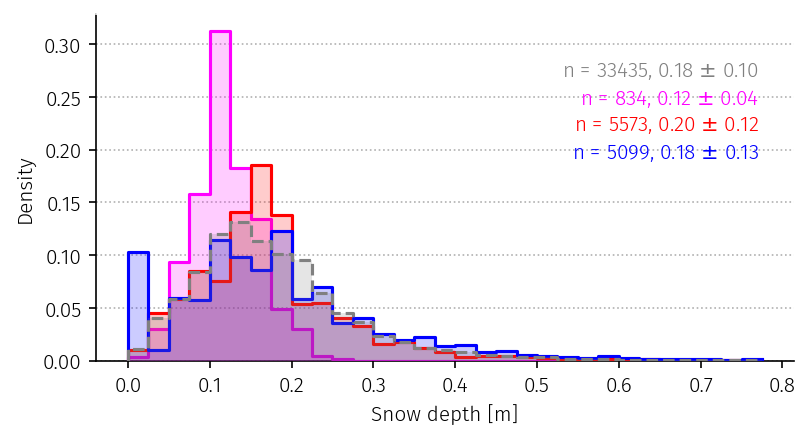

In [233]:
bw = 0.025
bin_edges = np.arange(0,.8,bw)
bc = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

fig, ax = plt.subplots(1,1, figsize=(6,3),dpi=150)


hist, bin_edges = np.histogram(df_f['snow_depth'], bins=bin_edges, density=True)
ax.step([0]+list(bc+bw/2), [0]+list(hist*bw),color='grey', ls='--',zorder=200)
t = ax.bar(bc, hist*bw,
            width=bw,
            alpha=.2,
            color='grey',zorder=100
            )
n = len(df_f['snow_depth'])
mean = np.nanmean(df_f['snow_depth'])
std = np.nanstd(df_f['snow_depth'])
ax.text(0.95, 0.87, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax.transAxes, ha='right', va='top', color='grey')


hist, bin_edges = np.histogram(df_QL['snow_depth'], bins=bin_edges, density=True)
ax.step([0]+list(bc+bw/2), [0]+list(hist*bw),color='magenta',zorder=8)
t = ax.bar(bc, hist*bw,
            width=bw,
            alpha=.2,
            color='magenta',zorder=5
            )
n = len(df_QL['snow_depth'])
mean = np.nanmean(df_QL['snow_depth'])
std = np.nanstd(df_QL['snow_depth'])
ax.text(0.95, 0.79, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax.transAxes, ha='right', va='top', color='magenta')

hist, bin_edges = np.histogram(df_master['snow_depth'] * 0.88, bins=bin_edges, density=True)
ax.step([0]+list(bc+bw/2), [0]+list(hist*bw),color='red',zorder=15)
t = ax.bar(bc, hist*bw,
            width=bw,
            alpha=.2,
            color='red',zorder=10
            )
n = len(df_master['snow_depth'])
mean = np.nanmean(df_master['snow_depth'])
std = np.nanstd(df_master['snow_depth'])
ax.text(0.95, 0.71, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax.transAxes, ha='right', va='top', color='red')

hist, bin_edges = np.histogram(df_master['snow_depth_peakiness'], bins=bin_edges, density=True)
ax.step([0]+list(bc+bw/2), [0]+list(hist*bw),color='blue',zorder=15)
t = ax.bar(bc, hist*bw,
            width=bw,
            alpha=.2,
            color='blue',zorder=10
            )
n = len(df_master['snow_depth_peakiness'][~np.isnan(df_master['snow_depth_peakiness'])])
mean = np.nanmean(df_master['snow_depth_peakiness'])
std = np.nanstd(df_master['snow_depth_peakiness'])
ax.text(0.95, 0.63, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax.transAxes, ha='right', va='top', color='blue')
    
ax.set_xlabel('Snow depth [m]')
ax.set_ylabel('Density')


ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.grid(ls=':',axis='y')

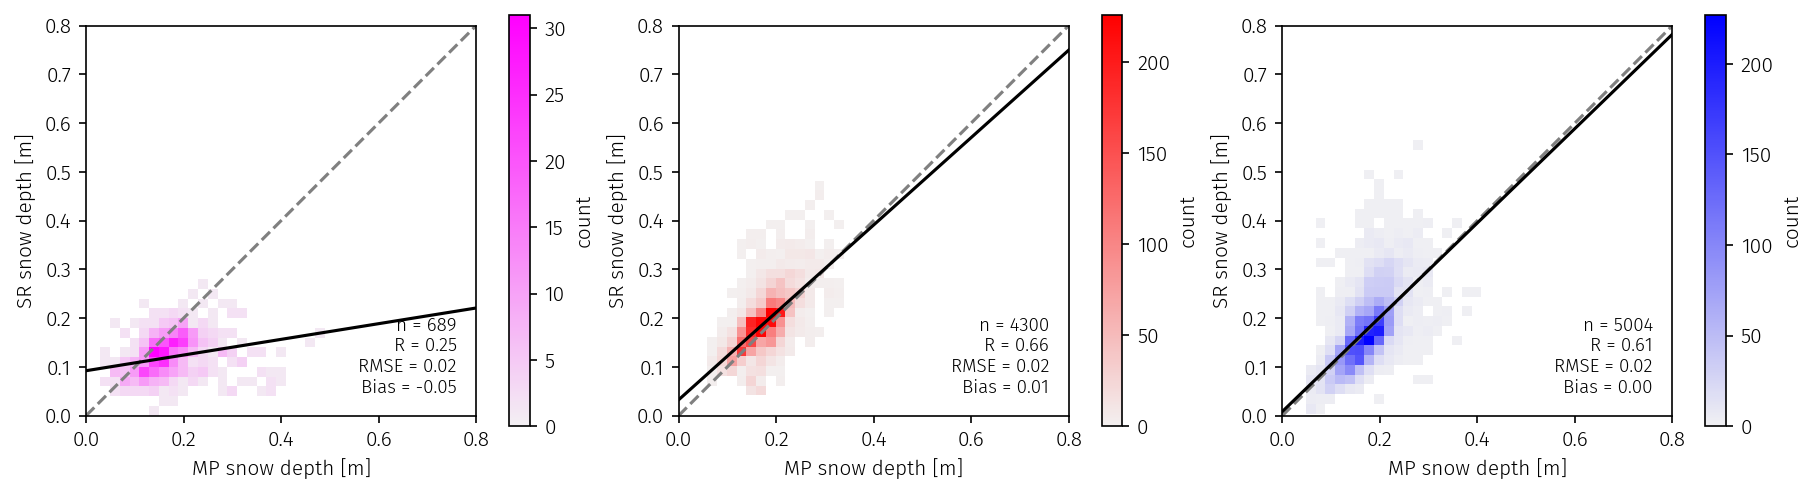

In [232]:
cmaps = [ sns.color_palette("light:magenta", as_cmap=True), sns.color_palette("light:red", as_cmap=True), sns.color_palette("light:blue", as_cmap=True), sns.color_palette("light:saddlebrown", as_cmap=True)]

fig, ax = plt.subplots(1,3, figsize=(12,4),dpi=150, constrained_layout=True)


x = df_QL['MP_snow_depth'].apply(lambda x: np.nanmean(x))
y = df_QL['snow_depth']
c = df_master['MP_snow_depth'].apply(lambda x: len(x))

mask = c > 1
x=x[mask]
y=y[mask]

linr = linregress(x,y)
bias = np.nanmean(y-x)
ax[0].plot([0,.8],[0,.8], color='grey', ls='--')
xs = np.linspace(0,.8,100)
ax[0].plot(xs, linr.slope*xs + linr.intercept, color='black')
# scat = ax.scatter(x,y,c=c, marker='x', alpha=1)
sns.histplot(x=x,y=y,ax=ax[0],
            cmap=cmaps[0],
            bins=30,
            binwidth=.02,
            cbar=True,
            stat='count',
            cbar_kws={'shrink': .7, 'label': 'count'},

            )
n = len(x)
ax[0].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[0].transAxes, ha='right', va='bottom', size=9)


mask = list(df_master['ATM_classes'] == 0)
x = df_master['MP_snow_depth_rolled_21'].apply(lambda x: np.nanmean(x))[mask]
y = df_master['snow_depth_rolled_21'][mask]
c = df_master['MP_snow_depth'].apply(lambda x: len(x))[mask]

mask = c > 1
x=x[mask]
y=y[mask]

linr = linregress(x,y)
bias = np.nanmean(y-x)
ax[1].plot([0,.8],[0,.8], color='grey', ls='--')
xs = np.linspace(0,.8,100)
ax[1].plot(xs, linr.slope*xs + linr.intercept, color='black')
# scat = ax.scatter(x,y,c=c, marker='x', alpha=1)
sns.histplot(x=x,y=y,ax=ax[1],
            cmap=cmaps[1],
            bins=30,
            binwidth=.02,
            cbar=True,
            stat='count',
            cbar_kws={'shrink': .7, 'label': 'count'},

            )
n = len(x)
ax[1].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[1].transAxes, ha='right', va='bottom', size=9)

mask = list(df_master['ATM_classes'] == 0)

x = df_master['MP_snow_depth_rolled_13'].apply(lambda x: np.nanmean(x))[mask]
y = df_master['snow_depth_peakiness_rolled_13'][mask]
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

mask2 = (x>0) & (y>0)
x = x[mask2]
y = y[mask2]
# c = df_master['MP_snow_depth'].apply(lambda x: len(x))
linr = linregress(x,y)
bias = np.nanmean(y-x)
ax[2].plot([0,.8],[0,.8], color='grey', ls='--')
xs = np.linspace(0,.8,100)
ax[2].plot(xs, linr.slope*xs + linr.intercept, color='black')
sns.histplot(x=x,y=y,ax=ax[2],
            cmap=cmaps[2],
            bins=30,
            binwidth=.02,
            cbar=True,
            stat='count',
            cbar_kws={'shrink': .7, 'label': 'count'},

            )
n = len(x)
ax[2].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[2].transAxes, ha='right', va='bottom', size=9)



for a in ax:
    a.set_aspect('equal')  
    a.set_xlim(0,.8)
    a.set_ylim(0,.8)
    a.set_xlabel('MP snow depth [m]')
    a.set_ylabel('SR snow depth [m]')
# fig.colorbar(scat)


In [228]:
mask

0        True
1        True
2        True
3        True
4        True
        ...  
5568     True
5569    False
5570     True
5571    False
5572    False
Name: MP_snow_depth, Length: 5004, dtype: bool

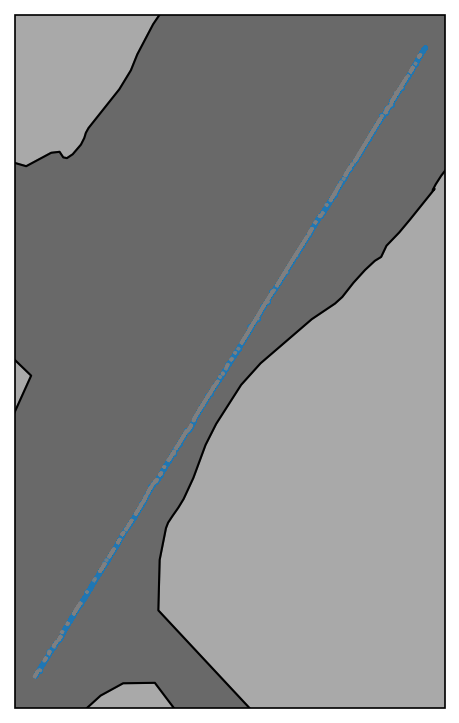

In [196]:
import cartopy.feature as cfeature

fig, ax = plt.subplots(1,1, figsize=(6,6),dpi=150, subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=80, central_longitude=-50, satellite_height=3500000)})

ax.add_feature(cfeature.LAND, color='darkgrey')
ax.add_feature(cfeature.OCEAN, color='dimgrey')
ax.coastlines(resolution='10m')

ax.scatter(df_f['x'], df_f['y'],s=1, transform=ccrs.epsg(3413))
# ax.scatter(df_wavelet['x'], df_wavelet['y'],s=1, transform=ccrs.epsg(3413))


for fp in df_master['footprints']:
    ax.plot(*fp.exterior.xy, transform=ccrs.epsg(3413), color='grey', alpha=.5)